In [260]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions
from keras.applications.inception_v3 import preprocess_input

from keras.preprocessing import image

from keras.models import Model, Sequential
from keras.layers import Input, Dense

import time
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## State of the art image classifier

<a href="http://www.image-net.org/">ImageNET</a> is an anual object recognition competition containing a databasis of at least one million labeled images. The objective is to design the algorithm that can better predict the labels and sublabels of the images with best accuracy. The winner algorithms of ImageNET are known to be the state-of-the-art of image recognition. 

Keras has a built-in inplementation of several such winning algorithms, which can be used "as is". In this notebook we will implement the algorithm InceptionV3. When applied to the datased of ImageNET 2012, InceptionV3 achieves impressively more than 96% accuracy for 1000 classes. According to this <a href="https://karpathy.github.io/2014/09/02/what-i-learned-from-competing-against-a-convnet-on-imagenet/">blog post</a>, this is more than humans can achieve!

In [9]:
inception_classifier = InceptionV3(include_top=True, weights='imagenet')

In [ ]:
inception_classifier.summary()

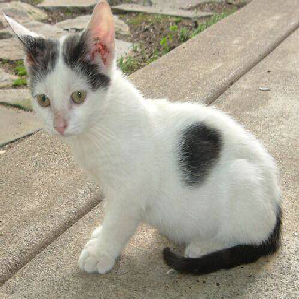

In [10]:
img_path = 'dataset/train/cats/cat.3.jpg'
img = image.load_img(img_path, target_size=(299, 299))
img

In [11]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [12]:
prediction = inception_classifier.predict(x)

## Predicting a class

The InceptionV3 network outputs for each image a vector with 1000 entries, each one corresponding to the probability that the image is one of the classes in the original image-net challenge (http://image-net.org/challenges/LSVRC/2014/browse-synsets). Usually the top 4-5 predictions are the most significant for the image.

The function "decode_predictions" converts the probability into "human-friendly" labels.

In [6]:
decode_predictions(prediction, top=4)

[[('n02124075', 'Egyptian_cat', 0.55996829),
  ('n02123597', 'Siamese_cat', 0.11946183),
  ('n02123045', 'tabby', 0.037323385),
  ('n03223299', 'doormat', 0.022137968)]]

## How to transform these 1000 classes into a prediction for cats and dogs?

A first idea is to build a classifier on top of the predictions. It receives the 1000-dimensional vector as features and trains a network that can distinguish two classses, cats and dogs. For the sake of this tutorial, this transformation has already been carried out using keras (see the code below for details on how to do this using keras "flow" generators). Since the inception architecture is huge, in a normal computer such feature extraction can take very long.

The "deep features" have been saved in the file /dataset/deep_features.csv and the corresponding classes in /dataset/deep_classes.csv

In [203]:
deep_features_train = np.loadtxt('dataset/deep_features.csv', delimiter=',')
deep_classes_train = np.loadtxt('dataset/deep_classes.csv', delimiter=',')

In [204]:
linear_model = LogisticRegression()
linear_model.fit(features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [ ]:
deep_features_test = np.load('deep_features_test.csv',delimiter=',')
deep_classes_test = np.load('deep_classes_test.csv',delimiter=',')

In [211]:
def predictor(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    probabilities = inception_classifier.predict(x)
    prediction = linear_model.predict_proba(probabilities)
    
    return prediction

## Finally evaluating our state-of-the-art model on random images

In [205]:
test_set = os.listdir('dataset/test/cats') + os.listdir('dataset/test/dogs')

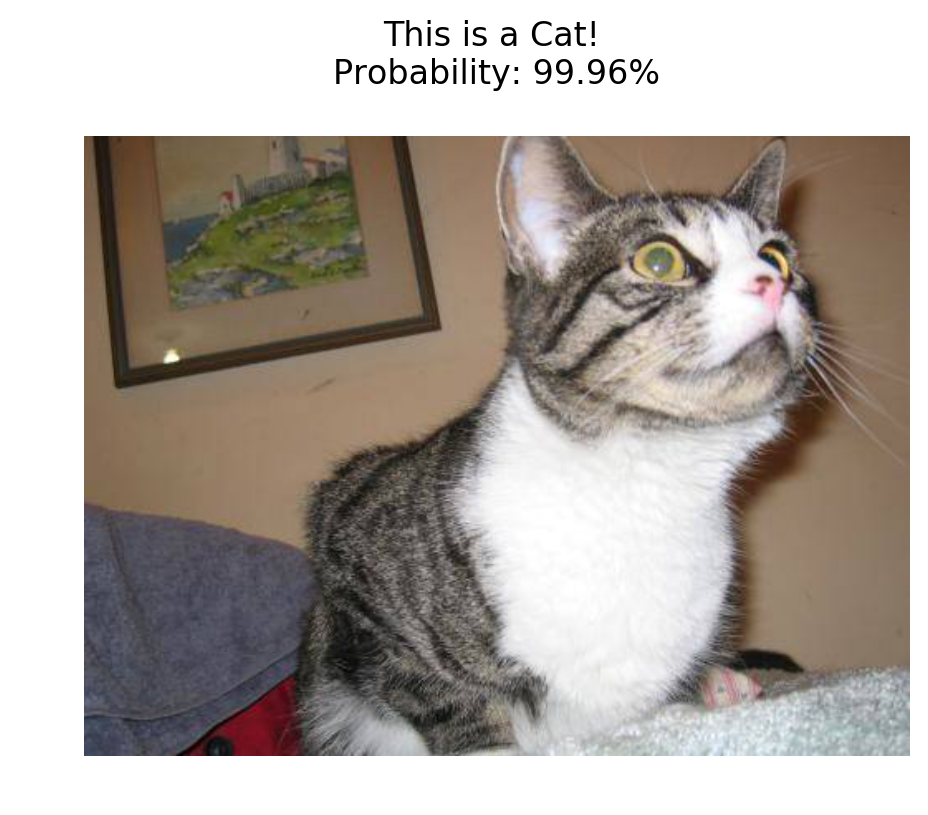

In [265]:
i = np.random.randint(len(test_set))

dic = {0:'Cat',1:'Dog'} 

animal = test_set[i]
if 'cat' in animal:
    img_path = 'dataset/test/cats/'+animal
    test_image = image.load_img(img_path, target_size=(299, 299))
    show_image = cv2.imread(img_path)
elif 'dog' in animal:
    img_path = 'dataset/test/dogs/'+animal
    test_image = image.load_img(img_path, target_size=(299, 299))
    show_image = cv2.imread(img_path)
    
pred = predictor(test_image)[0][0]

show_image = cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB)

plt.title('This is a '+dic[pred<0.5]+'! \nProbability: '+str(round(100*((1-pred)*(pred<0.5)+pred*(pred>0.5)),2))+'%\n')
plt.imshow(show_image);
plt.axis('off');

# .... on the S2DS cat...

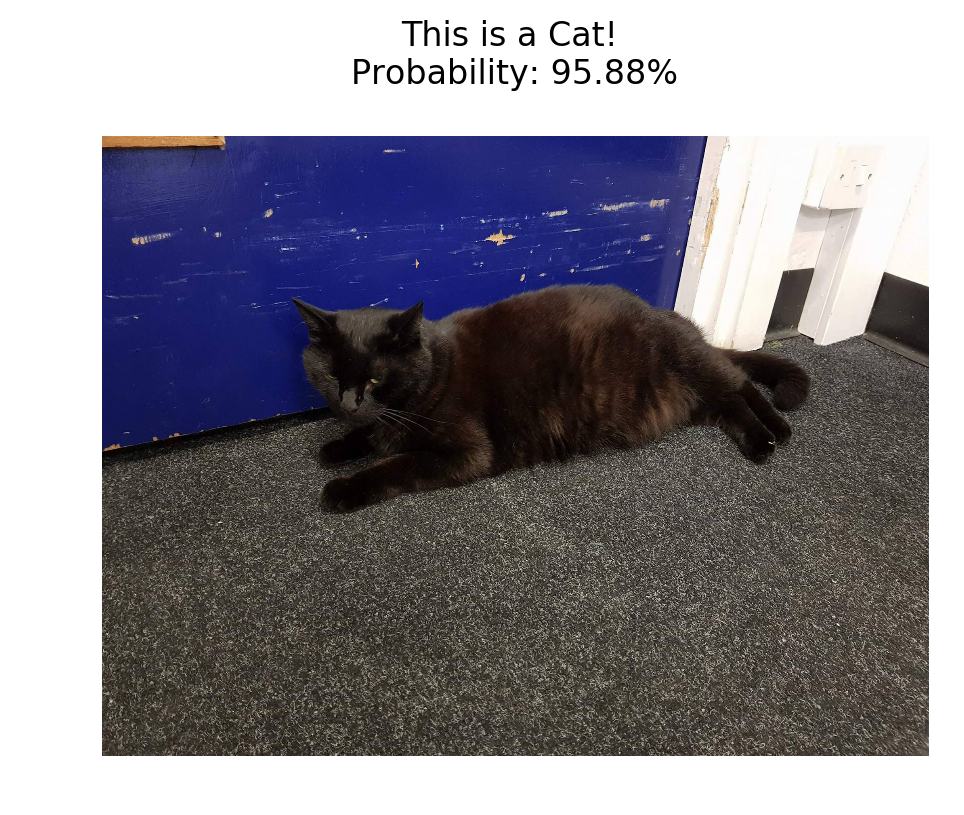

In [264]:
img_path = 'dataset/batman.jpg'
test_image = image.load_img(img_path, target_size=(299, 299))
show_image = cv2.imread(img_path)


pred = predictor(test_image)[0][0]

show_image = cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB)

plt.title('This is a '+dic[pred<0.5]+'! \nProbability: '+str(round(100*((1-pred)*(pred<0.5)+pred*(pred>0.5)),2))+'%\n')
plt.imshow(show_image);
plt.axis('off');

## and on random people!!! :D

In [ ]:
img_path = 'dataset/me.jpg'
test_image = image.load_img(img_path, target_size=(299, 299))
show_image = cv2.imread(img_path)


pred = predictor(test_image)[0][0]

show_image = cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB)

plt.title('This is a '+dic[pred<0.5]+'! \nProbability: '+str(round(100*((1-pred)*(pred<0.5)+pred*(pred>0.5)),2))+'%\n')
plt.imshow(show_image);
plt.axis('off');

## Extracting "deep features". The following piece of code extracts deep features

The following piece of code extracts "deep features". It applies the inception predictor in all instances, extract the vector of probabilities and saves them into a file deep_features.csv. (Since it has to apply the inception predictor in all instances, it could take a couple of hours in a normal computer, or less in a good instance with GPU).

## Bonus:

Can you help me optimise the following code? What would be the right implementation if I were yo run it on a powerful Amazon EC2 instance

In [ ]:
# Builds a data flow
data_gen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
data_flow = data_gen.flow_from_directory('dataset/train/', batch_size=32, shuffle=True,
                                         target_size=(299,299), class_mode="binary")

In [136]:
batches = 0
# Extract features with batches of size 32

labels = np.zeros(9600)
features = np.zeros([9600, 1000])

start = time.time()
for x_batch, y_batch in data_flow:
    labels[batches*32:(batches+1)*32] = y_batch
    
    features[batches*32:(batches+1)*32] = inception_classifier.predict(x_batch)
    batches+=1
    
    if batches*32 >= 9600:
        break


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [137]:
np.savetxt('dataset/deep_features.csv', features, delimiter=',')
np.savetxt('dataset/deep_classes.csv', labels, delimiter=',')

## Correct test labels

In [181]:
data_gen_test = image.ImageDataGenerator(preprocessing_function=preprocess_input)
data_flow_test = data_gen.flow_from_directory('dataset/test/', batch_size=1, shuffle=False,
                                         target_size=(299,299), class_mode="binary")

Found 2402 images belonging to 2 classes.


In [199]:
batches = 0
start = time.time()

labels_test = np.zeros(2402) 
features_test = np.zeros([2402,1000])

start = time.time()

err = 0
for x_batch, y_batch in data_flow_test:
    labels_test[batches] = y_batch
    
    x_probs = inception_classifier.predict(x_batch)
    features_test[batches] = x_probs
    
    err += abs(model.predict(x_probs) - y_batch)
    
    batches+=1
    
    if batches % 100 == 0:
        print(1-err/batches)
    
    if batches >= 2400:
        break

end = time.time()

[ 0.97]
[ 0.965]
[ 0.96333333]
[ 0.96]
[ 0.96]
[ 0.95666667]
[ 0.95428571]
[ 0.95875]
[ 0.95666667]
[ 0.955]
[ 0.95818182]
[ 0.96166667]
[ 0.96461538]
[ 0.96714286]
[ 0.96866667]
[ 0.970625]
[ 0.97235294]
[ 0.97333333]
[ 0.97473684]
[ 0.976]
[ 0.97714286]
[ 0.97727273]
[ 0.97826087]
[ 0.97791667]


In [202]:
np.savetxt('dataset/deep_features_test.csv',features_test,delimiter=',')
np.savetxt('dataset/deep_classes_test.csv',labels_test,delimiter=',')